In [3]:
from PIL import Image
from os import listdir
import imageio as iio
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

datapath = './test_dataset/center_crop'
y_path = 'label.txt'
X_path = [f for f in listdir(datapath) if f.endswith('png')]
y=[]
X=[]

In [4]:
with open(f'{datapath}/{y_path}','r') as label_txt:
    y=list(map(lambda x: int(x.split()[0]),label_txt.readlines()))
    le = LabelEncoder()
    y = le.fit_transform(y)
    label_txt.close()

1000 1000


ValueError: Expected the lengths of `labels` to match the number of files in the target directory. len(labels) is 1000 while we found 0 files in directory center_crop.

In [5]:
#target 레이블 저장

for i in range(len(X_path)):
    img_path = X_path[i]
    img_data=[]
    img = Image.open(f'{datapath}/{img_path}')
    ih, iw = img.size
    pix = img.load()
    for py in range(100):
        temp = []
        for px in range(100):
            if py <ih and px < iw :
                pixel = pix[py,px]
                temp.append([pixel[0]/255,pixel[1]/255,pixel[2]/255])
            else :
                temp.append((0,0,0))
        img_data.append(temp)
    X.append(img_data[:])
print(f'{len(X)} datas')

1000 datas


In [6]:
X = np.asarray(X)
y= np.asarray(y)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.2,random_state=42)


In [59]:
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score,f1_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold, KFold
from keras.layers import LeakyReLU
from keras.callbacks import CSVLogger
score_acc = make_scorer(accuracy_score)
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')

In [12]:

def nn_func(activation
            ,optimizer, learning_rate, epochs,
            layers1, layers2, layers3, layers4, dropout_rate,dropout_prob,pooling_size,

            ):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    layers3 = round(layers3)
    layers4 = round(layers4)
    poolingSize = round(pooling_size)
    def cl_model():
      model = models.Sequential()
      model.add(Conv2D(100, (3, 3), activation=activation, input_shape=(100, 100,3)))
      model.add(MaxPooling2D(pool_size=(poolingSize, poolingSize)))
      model.add(Conv2D(layers1, (3, 3), activation=activation))
      model.add(MaxPooling2D(pool_size=(poolingSize, poolingSize)))
      model.add(Conv2D(layers2, (3, 3), activation=activation))
      model.add(Flatten())
      model.add(Dense(layers3, activation=activation))
      if dropout_prob > 0.5:
        model.add(Dropout(dropout_rate, seed=123))
      model.add(layers.Dense(layers4, activation=activation))
      model.add(Dense(10, activation='softmax'))
      model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
      return model
    model = cl_model()
    model.fit(train_images,train_labels,epochs=epochs,verbose=None)
    y_predict = np.argmax(model.predict(test_images, verbose=None),axis=1)
    # return f1_score(test_labels, np.argmax(y_predict,axis=1),average=None).mean()
    return accuracy_score(test_labels, y_predict)




In [6]:

params_nn ={
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'epochs':(20,100),
    'dropout_prob':(0,1),
    'dropout_rate':(0,0.3),
    'layers1':(10, 100),
    'layers2':(10, 100),
    'layers3':(10, 100),
    'layers4':(10, 100),
    'pooling_size':(2, 5)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_func, params_nn, random_state=111)
nn_bo.maximize(init_points=24, n_iter=4)

|   iter    |  target   | activa... | dropou... | dropou... |  epochs   |  layers1  |  layers2  |  layers3  |  layers4  | learni... | optimizer | poolin... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.3366    | 5.51      | 0.1691    | 0.1308    | 81.54     | 36.58     | 23.42     | 12.02     | 47.82     | 0.2463    | 2.364     | 4.972     |
| 2         | 0.3366    | 2.14      | 0.08119   | 0.2009    | 69.7      | 34.68     | 51.96     | 20.65     | 16.66     | 0.9018    | 5.558     | 4.522     |


KeyboardInterrupt: 

In [ ]:
params_nn = nn_bo.max['params']
learning_rate = params_nn['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn['activation'] = activationL[round(params_nn['activation'])]
params_nn['epochs'] = round(params_nn['epochs'])
params_nn['layers1'] = round(params_nn['layers1'])
params_nn['pooling_size'] = round(params_nn['pooling_size'])
params_nn['layers2'] = round(params_nn['layers2'])
params_nn['layers3'] = round(params_nn['layers3'])
params_nn['layers4'] = round(params_nn['layers4'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
             'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
             'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
             'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
params_nn['optimizer'] = optimizerD[optimizerL[round(params_nn['optimizer'])]]
print(params_nn)

{'activation': 'relu', 'dropout_prob': 0.21355594928740118, 'dropout_rate': 0.0893324107995704, 'epochs': 79, 'layers1': 11, 'layers2': 13, 'layers3': 76, 'layers4': 55, 'learning_rate': 0.225886505284512, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x000001291C494710>, 'pooling_size': 5}


In [61]:
#이전에 돌려서 얻은 하이퍼파라미터들
#수정함
params_nn={}
params_nn['activation'] = 'relu'
params_nn['epochs'] = 20
params_nn['layers1'] = 11
params_nn['layers2'] = 13
params_nn['layers3'] = 76
params_nn['layers4'] = 55
params_nn['learning_rate'] = 0.225886505284512
params_nn['optimizer'] = 'adam'
params_nn['pooling_size'] = 5
params_nn['dropout_prob'] = 0.2136
params_nn['dropout_rate'] = 0.08933


In [42]:
# def optimized_model():
#       model = models.Sequential()
#       model.add(Conv2D(100, (3, 3), activation=params_nn['activation'], input_shape=(100, 100,3)))
#       model.add(MaxPooling2D(pool_size=(params_nn['pooling_size'], params_nn['pooling_size'])))
#       model.add(Dropout(params_nn['dropout_rate'], seed=123))
#       model.add(Conv2D(params_nn['layers2'], (3, 3), activation=params_nn['activation']))
#       model.add(Flatten())
#       model.add(Dense(params_nn['layers3'], activation=params_nn['activation']))
#       if params_nn['dropout_prob'] > 0.5:
#         model.add(Dropout(params_nn['dropout_rate'], seed=123))
#       model.add(layers.Dense(params_nn['layers4'], activation=params_nn['activation']))
#       model.add(Dense(50,activation='relu'))
#       model.add(Dense(1, activation='sigmoid'))
#       model.compile(optimizer=params_nn['optimizer'],
#                     loss='binary_crossentropy',
#                     metrics=['accuracy'])
#       return model

In [66]:
def optimized_model2():
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Flatten())
  model.add(Dense(params_nn['layers3'], activation=params_nn['activation']))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(layers.Dense(params_nn['layers4'], activation=params_nn['activation']))
  model.add(Dense(50,activation='relu'))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Dense(50,activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=params_nn['optimizer'],
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [52]:
# def optimized_model3():
#   model = models.Sequential()
#   model.add(Conv2D(1, (1, 1), activation='relu', input_shape=(100, 100,3)))
#   model.add(Flatten())
#   model.add(Dense(params_nn['layers3'], activation=params_nn['activation']))
#   model.add(Dropout(params_nn['dropout_rate'], seed=123))
#   model.add(layers.Dense(params_nn['layers4'], activation=params_nn['activation']))
#   model.add(Dense(500,activation='relu'))
#   model.add(Dropout(params_nn['dropout_rate'], seed=123))
#   model.add(Dense(500,activation='relu'))
#   model.add(Dropout(params_nn['dropout_rate'], seed=123))
#   model.add(Dense(500,activation='relu'))
#   model.add(Dropout(params_nn['dropout_rate'], seed=123))
#   model.add(Dense(1, activation='sigmoid'))
#   model.compile(optimizer=params_nn['optimizer'],
#                 loss='binary_crossentropy',
#                 metrics=['accuracy'])
#   return model

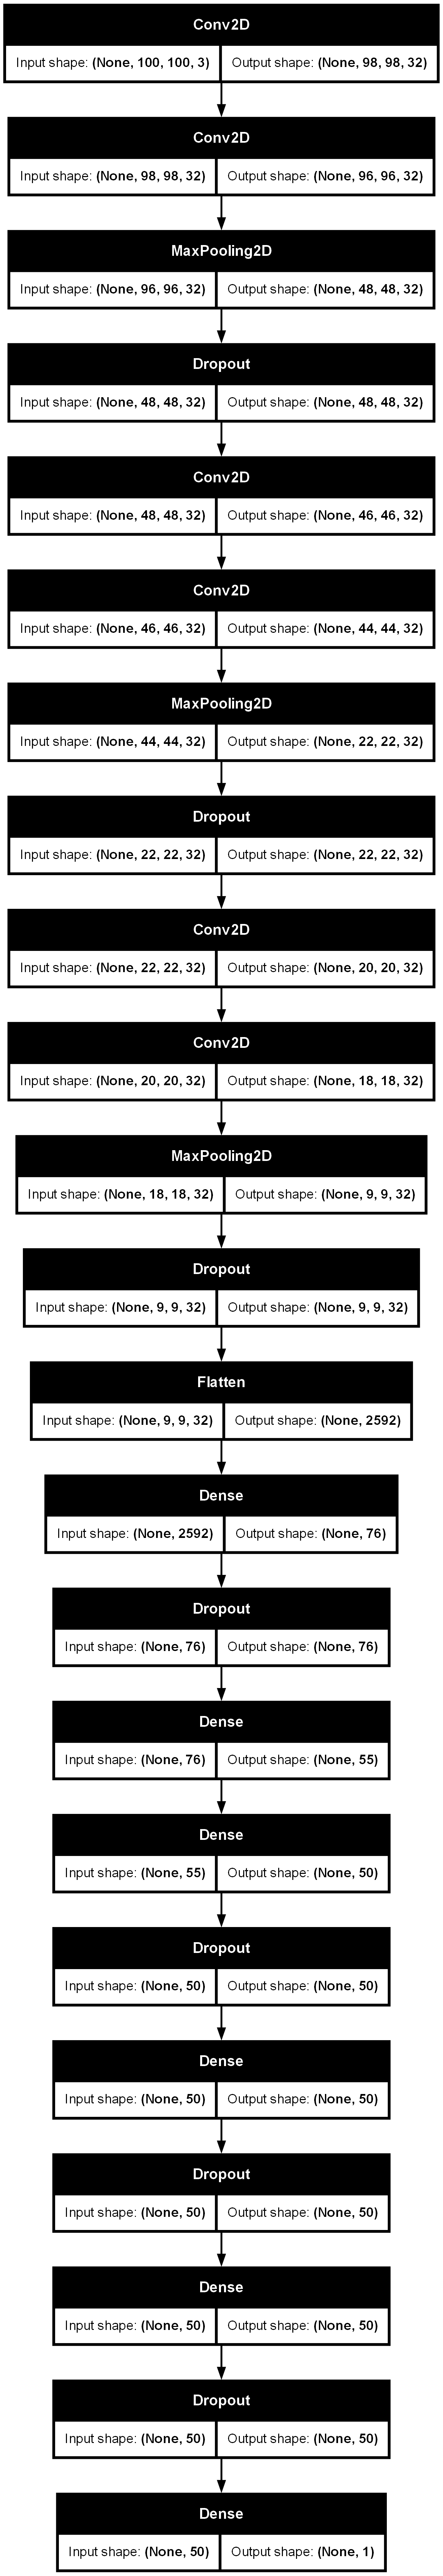

In [57]:
from tensorflow.keras.utils import plot_model
model = optimized_model2()
plot_model(model, to_file='model.png', show_shapes=True)

# Center crop

In [12]:

es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=optimized_model2, epochs=params_nn['epochs'], batch_size=200,
                         verbose=0)
nn.fit(train_images, train_labels, validation_data=(test_images, test_labels), verbose=1)
# model.fit(train_images,train_labels,epochs=params_nn['epochs'])
y_predict =nn.predict(test_images, verbose=None)
print(f"""Center-cropped Image
Accuracy : {accuracy_score(test_labels, y_predict)}
F1 Score : {f1_score(test_labels, y_predict, average=None)}
""")


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.5143 - loss: 0.6916 - val_accuracy: 0.6400 - val_loss: 0.6728
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.5143 - loss: 0.6971 - val_accuracy: 0.6400 - val_loss: 0.6837
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5350 - loss: 0.6905 - val_accuracy: 0.6400 - val_loss: 0.6777
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.5562 - loss: 0.6852 - val_accuracy: 0.6400 - val_loss: 0.6808
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.5453 - loss: 0.6890 - val_accuracy: 0.5150 - val_loss: 0.6903
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.5378 - loss: 0.6894 - val_accuracy: 0.6400 - val_loss: 0.6813
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5432 - loss: 0.6868 - val_accuracy: 0.6400 - val_loss: 0.6795
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.5308 - loss: 0.6904 - val_accuracy: 0.6150 - val_loss:

In [22]:
# print(nn.predict(test_images, verbose=None))
y_predict = nn.predict(test_images, verbose=None)
print(f"""Center-cropped Image
Accuracy : {accuracy_score(test_labels, y_predict)}
F1 Score : {f1_score(test_labels, y_predict, average=None)}
""")


Center-cropped Image
Accuracy : 0.5066666666666667
F1 Score : [0.4751773  0.53459119]



# Padding

In [13]:
datapath = './test_dataset/padding'
X_path = [f for f in listdir(datapath) if f.endswith('png')]
padding_y=[]
padding_X=[]
#target 레이블 저장
with open(f'{datapath}/{y_path}','r') as label_txt:
    padding_y=list(map(lambda x: int(x.split()[0]),label_txt.readlines()))
    le = LabelEncoder()
    padding_y = le.fit_transform(padding_y)
    label_txt.close()
print(len(X_path))
for i in range(len(X_path)):
    img_path = X_path[i]
    img_data=[]
    img = Image.open(f'{datapath}/{img_path}')
    ih, iw = img.size
    pix = img.load()
    for py in range(100):
        temp = []
        for px in range(100):
            if py <ih and px < iw :
                pixel = pix[py,px]
                temp.append([pixel[0]/255,pixel[1]/255,pixel[2]/255])
            else :
                temp.append((0,0,0))
        img_data.append(temp)
    padding_X.append(img_data[:])
print(f'{len(padding_X)} data')
padding_X = np.asarray(padding_X)
padding_y = np.asarray(padding_y)

1000
1000 data


In [14]:
p_train_images, p_test_images, p_train_labels, p_test_labels = train_test_split(padding_X,padding_y,test_size = 0.2, random_state=42)

In [15]:
print(len(p_train_images))

800


In [67]:
# model = optimized_model2()
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=0)
nn = KerasClassifier(build_fn=optimized_model, epochs=50, batch_size=200,
                         verbose=0)
history=nn.fit(train_images, train_labels, validation_data=(test_images, test_labels), verbose=1,
               callbacks=[CSVLogger('asd.log', append=True)]
              )
# model.fit(train_images,train_labels, epochs = 15)
# y_predict = np.argmax(model.predict(test_images, verbose=None),axis=1)
y_predict=nn.predict(test_images, verbose=None)
print(f"""Padding Image
Accuracy : {accuracy_score(p_test_labels, y_predict)}
F1 Score : {f1_score(p_test_labels, y_predict, average=None)}
""")


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - accuracy: 0.4497 - loss: 0.6995 - val_accuracy: 0.6150 - val_loss: 0.6922
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.5217 - loss: 0.6930 - val_accuracy: 0.6400 - val_loss: 0.6902
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.5428 - loss: 0.6920 - val_accuracy: 0.6400 - val_loss: 0.6838
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.5242 - loss: 0.6910 - val_accuracy: 0.6400 - val_loss: 0.6726
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.5303 - loss: 0.6908 - val_accuracy: 0.6400 - val_loss: 0.6737
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - accuracy: 0.5538 - loss: 0.6892 - val_accuracy: 0.6400 - val_loss: 0.6734
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.5185 - loss: 0.6927 - val_accuracy: 0.6350 - val_loss: 0.6890
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.5168 - loss: 0.6919 - val_accuracy: 0.6400 - val_loss:

padding이 정확도가 더 높다

In [27]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

AttributeError: 'KerasClassifier' object has no attribute 'history'

Found 0 images belonging to 0 classes.


TypeError: Invalid shape (0, 100, 100, 3) for image data

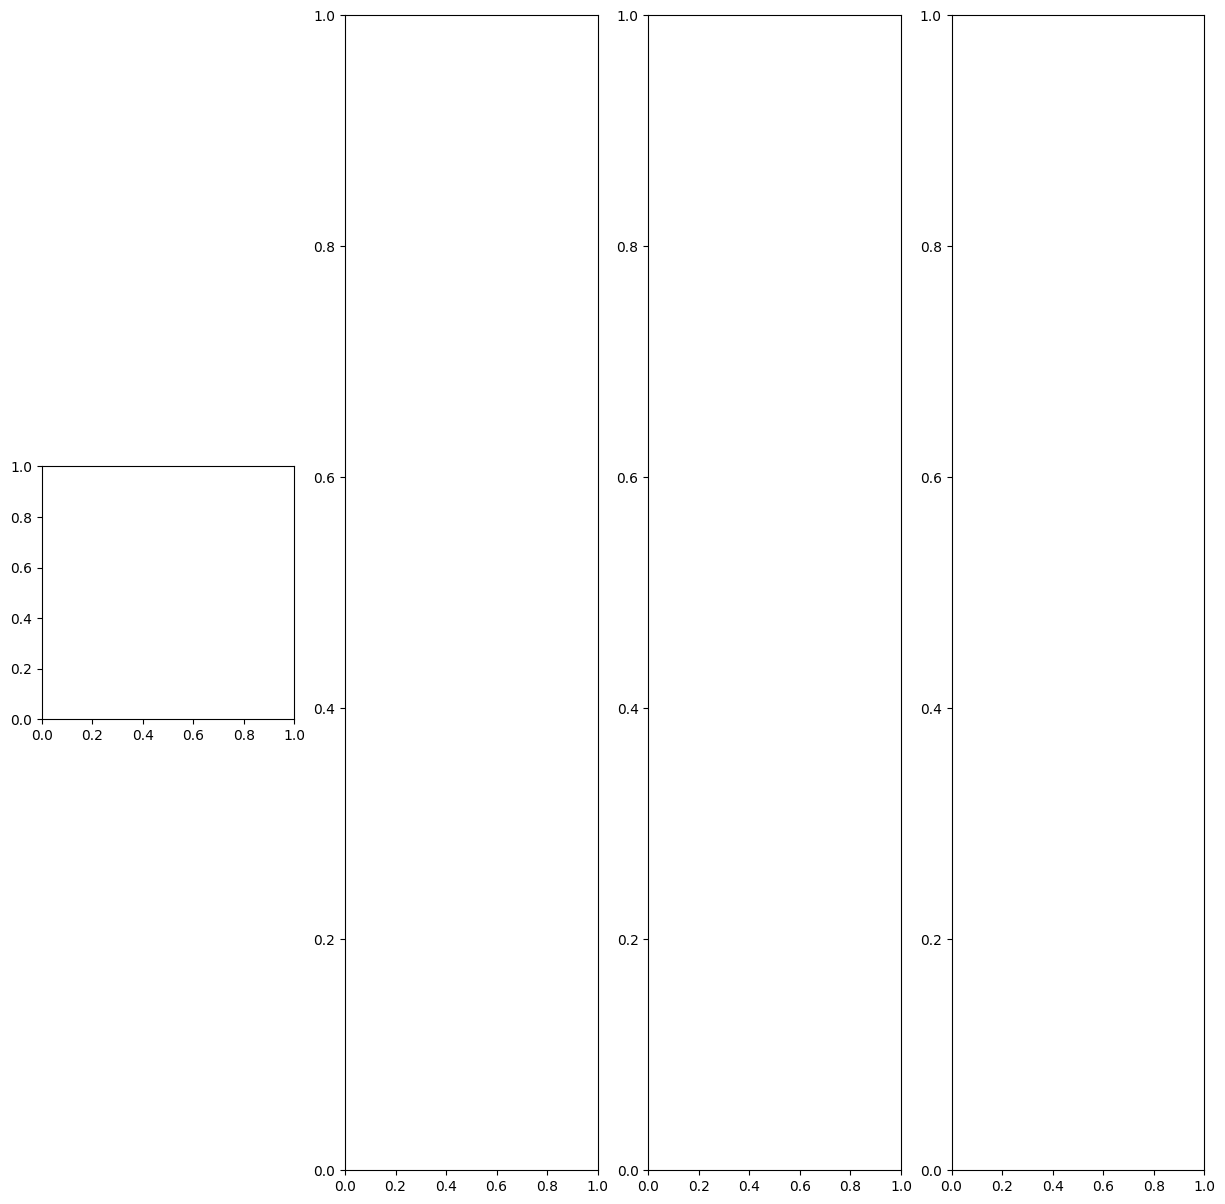

In [6]:
datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(directory = './test_dataset/center_crop/', target_size = (100,100), color_mode = 'rgb', batch_size = 1, class_mode = 'binary', seed = 2020)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')